In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle as pickle
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.parametric_coupling as pmc
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(ge_time=67, ef_amp=0.5, ro_amp=1, ef_ssm=-0.257, RO_LO=6.6247, IQ_angle=205, ro_dur=4000, qubit_thr=[-10000, -600], ro_freq=6.7275, RO_IF=None, RO_LO_pwr=16, qubit_id=q1, ge_ssm=-0.114, ROIF=0.10280000000000022, ge_amp=0.5, ef_time=76)
Qubit(ge_time=23.610582067254867, ef_amp=1, ro_amp=1, ef_ssm=-0.224, RO_LO=6.6247, IQ_angle=85, ro_dur=4000, qubit_thr=[-10000, 1900], ro_freq=6.6556, RO_IF=None, RO_LO_pwr=16, qubit_id=q2, ge_ssm=-0.154, ROIF=0.030899999999999928, ge_amp=1, ef_time=None)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [4]:
def swap_gate_sweep(freq_list, reps,sweep_time, filename="swap_gate_sweep.pkl"):
    """
    Run a swap gate sweep by performing parametric coupling experiments at each frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
    num_steps = 51  # Number of time steps for the parametric coupling experiment

    # Initialize arrays to store results
    I1_data = np.zeros((len(freq_list),  num_steps))
    Q1_data = np.zeros((len(freq_list), num_steps))
    I2_data = np.zeros((len(freq_list),  num_steps))
    Q2_data = np.zeros((len(freq_list), num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I1_data = saved_data["I1_data"]
        Q1_data = saved_data["Q1_data"]
        I2_data = saved_data["I2_data"]
        Q2_data = saved_data["Q2_data"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, len(freq_list)):
        frequency = freq_list[i]

        # Perform parametric coupling experiment
        pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=1.5,
            sweep_time=sweep_time,
            verbose=False,
        )
        wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
        )

        # Retrieve raw IQ data from the acquired values
        # I1_raw = values.rec_readout_1[0][:reps * num_steps]
        # Q1_raw = values.rec_readout_1[1][:reps * num_steps]
        # I2_raw = values.rec_readout_2[0][:reps * num_steps]
        # Q2_raw = values.rec_readout_2[1][:reps * num_steps]
        I1_raw = values.rec_avg_vs_pats_1[0]
        Q1_raw = values.rec_avg_vs_pats_1[1]
        I2_raw = values.rec_avg_vs_pats_2[0]
        Q2_raw = values.rec_avg_vs_pats_2[1]

        # Store results
        I1_data[i] = I1_raw
        Q1_data[i] = Q1_raw
        I2_data[i] = I2_raw
        Q2_data[i] = Q2_raw

        # Save results to file after each step
        with open(filename, "wb") as f: 
            pickle.dump(
                {
                    "freq_list": freq_list,
                    "I1_data": I1_data,
                    "Q1_data": Q1_data,
                    "I2_data": I2_data,
                    "Q2_data": Q2_data,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

    return I1_data, Q1_data, I2_data, Q2_data

In [ ]:
last_swap_freq=-.021
freq_list = np.linspace(-0.017, -0.021, 21)
sweep_time = 500
swap_gate_sweep(freq_list, reps = 1000, sweep_time = sweep_time)

In [6]:
  # Check if the file exists
filename = 'swap_gate_sweep.pkl'
if os.path.exists(filename):
    print(f"Loading existing data from {filename}")
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Load saved data
    I1_data = saved_data["I1_data"]
    Q1_data = saved_data["Q1_data"]
    I2_data = saved_data["I2_data"]
    Q2_data = saved_data["Q2_data"]
    freq_list = saved_data['freq_list']
    last_completed_step = saved_data["last_completed_step"]

Loading existing data from swap_gate_sweep.pkl


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1_data
im1 = axes[0, 0].imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 0].set_title('I1 Average')
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('Frequency')
fig.colorbar(im1, ax=axes[0, 0])

# Plot Q1_data
im2 = axes[0, 1].imshow(Q1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 1].set_title('Q1 Average')
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('Frequency')
fig.colorbar(im2, ax=axes[0, 1])

# Plot I2_data
im3 = axes[1, 0].imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 0].set_title('I2 Average')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 0].set_ylabel('Frequency')
fig.colorbar(im3, ax=axes[1, 0])

# Plot Q2_data
im4 = axes[1, 1].imshow(Q2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 1].set_title('Q2 Average')
axes[1, 1].set_xlabel('Time (ns)')
axes[1, 1].set_ylabel('Frequency')
fig.colorbar(im4, ax=axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
max_index_I2_data = np.unravel_index(np.argmax(I2_data),I2_data.shape)
plt.imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I2_data[0]],color='black', label = f'freq = {freq_list[max_index_I2_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

In [6]:
max_index_I1_data = np.unravel_index(np.argmin(I1_data),Q1_data.shape)
plt.imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I1_data[0]],color='black', label = f'freq = {freq_list[max_index_I1_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

NameError: name 'I1_data' is not defined

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 1000
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 7.193041 sec
Captured 17 buffers (2.363395 buffers per sec)
Captured 52224 records (7260.350818 records per sec)
Transferred 855638016 bytes (118953587.795108 bytes per sec)


<Figure size 800x800 with 0 Axes>

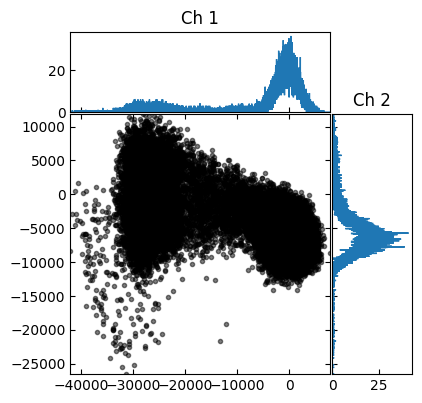

<Figure size 800x800 with 0 Axes>

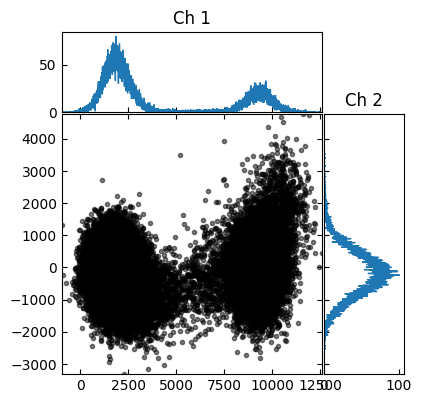

In [29]:
num_steps=51
reps=1000
frequency=-.0192
sweep_time =0.5*num_steps/abs(frequency)#7
phase = 0
spec_amp=1.8
pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=spec_amp,
            sweep_time=sweep_time,
            phase=phase,
            verbose=False,
        )
wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
        )

In [28]:
IQ_df = plotting.get_IQ_averages(values)
print(IQ_df['I1'])
# print(IQ_df['I2'])

0    -10599.844434
1    -10459.348844
2     -9018.369598
3     -5973.097499
4     -4612.826448
5     -2974.346195
6     -1804.906213
7      -964.736660
8     -1358.672185
9     -2576.068620
10    -3957.245876
11    -5918.910567
12    -6937.554132
13    -8775.174744
14    -8454.382941
15    -7937.494461
16    -6782.390113
17    -5209.100695
18    -4380.981894
19    -2585.954613
20    -1511.690162
21    -1269.414443
22    -1576.930767
23    -2386.948192
24    -3709.587496
25    -4724.078767
26    -5731.606121
27    -6269.055943
28    -5422.388091
29    -5623.568318
30    -2166.742125
31    -3611.953880
32    -1168.670123
33    -1754.362187
34    -2788.936795
35     -925.096110
36    -4156.878688
37    -1711.821052
38    -6521.285128
39    -2848.968107
40    -6059.869011
41    -2792.823692
42    -5156.509537
43    -2769.611823
44    -3168.954857
45    -3096.528627
46    -1255.692720
47    -1644.363511
48     -707.625955
49     -855.357962
50    -1414.252223
Name: I1, dtype: float64


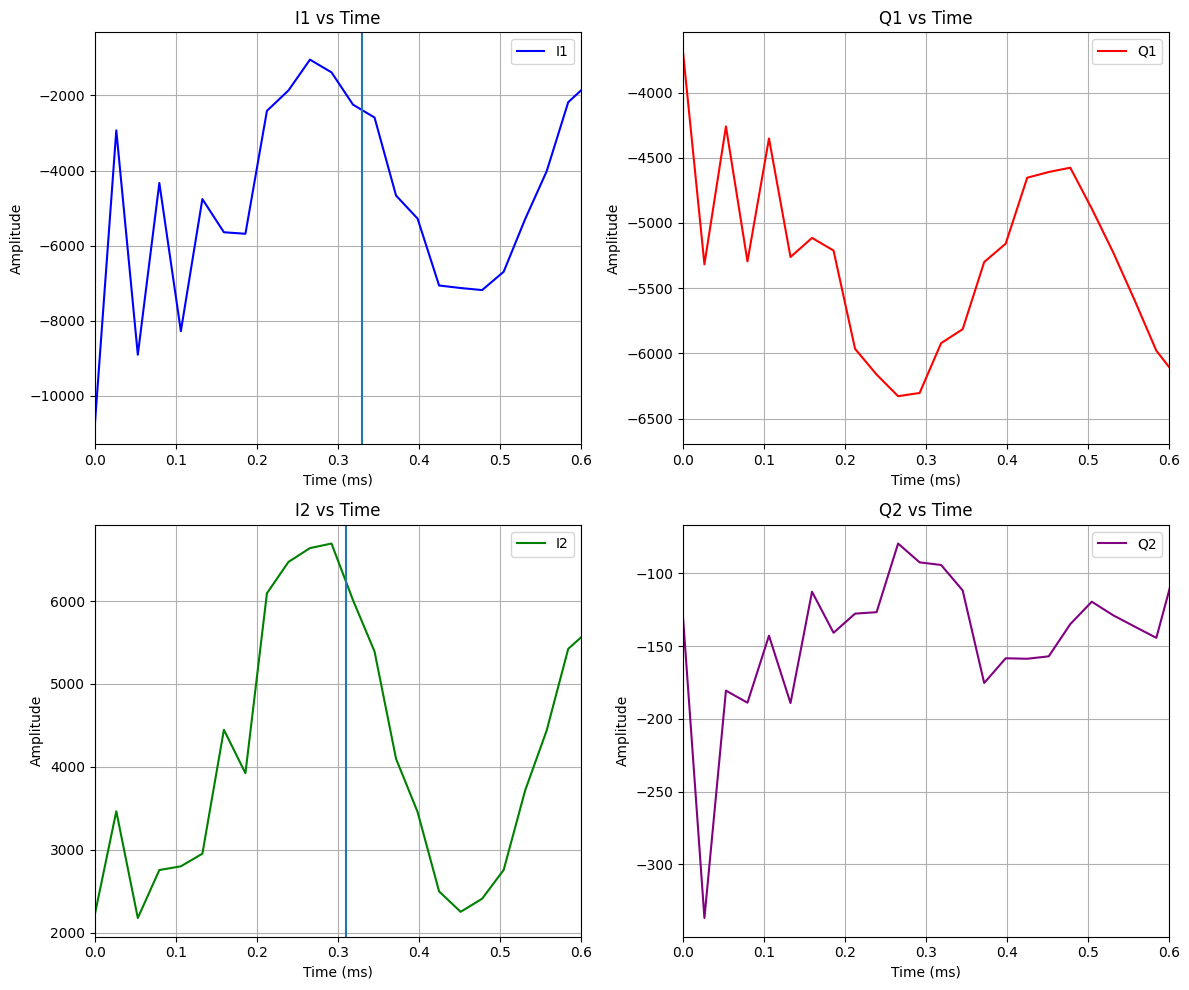

In [30]:
times = np.linspace(0, sweep_time / 1000, num_steps)  # x-axis values in milliseconds
IQ_df = plotting.get_IQ_averages(values)
# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1
axes[0, 0].plot(times, IQ_df['I1'], color='blue', label='I1')
axes[0, 0].set_title('I1 vs Time')
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Amplitude')
axes[0,0].set_xlim([0,0.6])
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].axvline(330/1000)

# Plot Q1
axes[0, 1].plot(times, IQ_df['Q1'], color='red', label='Q1')
axes[0, 1].set_title('Q1 vs Time')
axes[0, 1].set_xlabel('Time (ms)')
axes[0, 1].set_ylabel('Amplitude')
axes[0,1].set_xlim([0,0.6])
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot I2
axes[1, 0].plot(times, IQ_df['I2'], color='green', label='I2')
axes[1, 0].set_title('I2 vs Time')
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True)
axes[1,0].set_xlim([0,0.6])
axes[1, 0].legend()
axes[1, 0].axvline(310/1000)

# Plot Q2
axes[1, 1].plot(times, IQ_df['Q2'], color='purple', label='Q2')
axes[1, 1].set_title('Q2 vs Time')
axes[1, 1].set_xlabel('Time (ms)')
axes[1, 1].set_ylabel('Amplitude')
axes[1,1].set_xlim([0,0.6])
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

RuntimeError


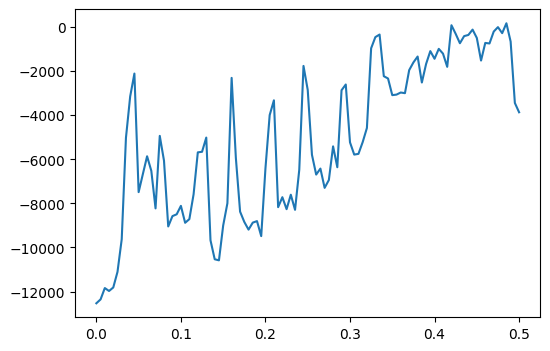



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
π_ge time = nan ns


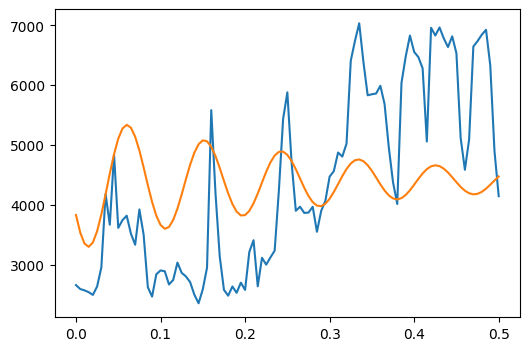



  freq: 10.96002408254006 +/- 0.4955642229807928
 gamma: 3.4938432955510326 +/- 3.0597197918150987
   amp: -1160.0125109182436 +/- 587.4420265987874
 phase: 29.277697843664615 +/- 30.72103341903112
offset: 4399.824891884019 +/- 150.1721811823807
pi_pulse time: 0.04562033771408663 +/- 0.4955642229807928
π_ge time = 45.620337714086624 ns


In [7]:
sweep_time=500
I1 = IQ_df['I1']
I2 = IQ_df['I2']
Q1 = IQ_df['Q1']
Q2= IQ_df['Q2']
Qrange1 = abs(np.max(Q1)-np.min(Q1))
Irange1 = abs(np.max(I1)-np.min(I1))
if Qrange1>Irange1:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q1,guess_vals=[3.4542658570,0.3,np.abs(np.max(Q1)-np.min(Q1)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I1,guess_vals=[3.4542658570,0.3,np.abs(np.max(I1)-np.min(I1)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
Qrange2 = abs(np.max(Q2)-np.min(Q2))
Irange2 = abs(np.max(I2)-np.min(I2))
if Qrange2>Irange2:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q2,guess_vals=[11,0.3,np.abs(np.max(Q2)-np.min(Q2)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I2,guess_vals=[11,0.3,np.abs(np.max(I2)-np.min(I2)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))